<a href="https://colab.research.google.com/github/sboonpan/PrProoject_Review_NN_Jigar_Partel_2015-/blob/main/Project_Review_NN_Jigar_Partel_2015%20%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [5]:
!pip install talib-binary
!pip install yfinance

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import warnings

import random

warnings.simplefilter("ignore")
%matplotlib inline

# Neural Network Programing

## Logistic Regression

In [7]:
def LoR_create_Xb(X):
    N = X.shape[0]
    ones = np.ones([N, 1])
    Xb = np.hstack([ones, X])
    return Xb

In [8]:
def LoR_find_W_local(X, Y, epoch = 1000, lr = 1, batch_size = 64, lambda1 = 0, lambda2 = 0):
    Xb = LoR_create_Xb(X)
    N = Xb.shape[0]
    D_1 = Xb.shape[1]
    W = np.random.randn(D_1, 1)/np.sqrt(D_1)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Yhat = LoR_find_Yhat(X, W)
            error = find_error(Y, Yhat, 'Entropy')
            error_list.append(error)
            S = np.dot(Xb.T, Y - Yhat)
        elif batch_size != N:
            X_mb, Y_mb = shuffle(X, Y, N, batch_size)
            Xb_mb = LoR_create_Xb(X_mb)
            Yhat_mb = LoR_find_Yhat(Xb_mb, W)
            error = find_error(Y_mb, Yhat_mb, 'Entropy')
            error_list.append(error)
            S = np.dot(Xb_mb.T, Y_mb - Yhat_mb)
        W = W + (lr/batch_size)*S - lambda1*np.sign(W) - lambda2*W
    return W, error_list

In [9]:
def LoR_find_Yhat(X, W):
    Xb = LoR_create_Xb(X)
    Z = np.dot(Xb, W)
    Yhat = 1/(1 + np.exp(-Z))
    return Yhat

In [10]:
def NN_create_WB(A0, HL):
    W = []
    B = []
    for i in range(len(HL)):
        if i == 0:
            W_i = np.random.randn(A0.shape[1], HL[0])/np.sqrt(HL[0])
        else:
            W_i = np.random.randn(HL[i-1], HL[i])/np.sqrt(HL[i])
        B_i = np.random.randn(1, HL[i])/np.sqrt(HL[i])
        W.append(W_i)
        B.append(B_i)
    return W, B

In [11]:
def NNC_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01, batch_size = 64, lambda1 = 0, lambda2 = 0, dropout = False, prob_drop = [0]):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        if batch_size == N:
            Z, A = NN_forward(A0, W, B, AF)
            error = find_error(T, A[-1], 'Entropy')
            error_list.append(error)
            SW, SB = NNC_backpropagation(A0, W, B, Z, A, T, AF, dropout, prob_drop)
        elif batch_size != N:
            A0_mb, T_mb = shuffle(A0, T, N, batch_size)
            Z_mb, A_mb = NN_forward(A0_mb, W, B, AF)
            error = find_error(T_mb, A_mb[-1], 'Entropy')
            error_list.append(error)
            SW, SB = NNC_backpropagation(A0_mb, W, B, Z_mb, A_mb, T_mb, AF, dropout, prob_drop)
        for j in range(L):
            W[j] = W[j] + (lr/batch_size)*SW[j] - lambda1*np.sign(W[j]) - lambda2*W[j]
            B[j] = B[j] + (lr/batch_size)*SB[j] - lambda1*np.sign(B[j]) - lambda2*B[j]
    return W, B, error_list

In [12]:
def NN_forward(A0, W, B, AF):
    Z = []
    A = []
    for i in range(len(AF)):
        if i == 0:
            Z_i = np.dot(A0, W[i]) + B[i]
        else:
            Z_i = np.dot(A[-1], W[i]) + B[i]
        A_i = NN_compute_A(Z_i, AF[i])
        Z.append(Z_i)
        A.append(A_i)
    return Z, A

In [13]:
def NN_compute_A(Z_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            A_i = 1/(1 + np.exp(-Z_i))
        elif af == 'tanh':
            A_i = (np.exp(Z_i) - np.exp(-Z_i))/(np.exp(Z_i) + np.exp(-Z_i))
        elif af == 'ReLU':
            A_i = Z_i * (Z_i > 0)
        elif af == 'softmax':
            A_i = np.exp(Z_i)/np.exp(Z_i).sum(axis=1, keepdims = True)
    elif type(af) == list:
        if af[0] == 'PReLU':
            A_i = Z_i * (Z_i > 0) + af[1] * Z_i * (Z_i <= 0)
    return A_i

In [14]:
def NNC_backpropagation(A0, W, B, Z, A, T, AF, dropout, prob_drop):
    L = len(AF)
    SW = []
    SB = []
    if dropout == True:
        DN = NN_random_DN(HL, prob_drop)
    for i in range(L - 1, -1, -1):
        if i == L - 1:
            Delta_i = T - A[i]
            Diff_i = 1
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)
            Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])
        Err_i = NN_compute_Err(Delta_i, Diff_i)
        
        if dropout == False:
            if i != 0:
                SW_i = np.dot(A[i-1].T, Err_i)
            else:
                SW_i = np.dot(A0.T, Err_i)
            SB_i = Err_i.sum(axis=0)
        elif dropout == True:
            if i != 0:
                SW_i = np.dot((A[i-1]*DN[i-1]).T, Err_i)
            else:
                SW_i = np.dot(A0.T, Err_i)
            if i == L - 1:
                SB_i = Err_i.sum(axis=0)
            else:
                SB_i = (Err_i*DN[i]).sum(axis=0)
        
        SW.append(SW_i)
        SB.append(SB_i)
    return SW[::-1], SB[::-1]

In [15]:
def NN_random_DN(HL, prob_drop):
    DN = []
    for i in range(len(HL)):
        Dropout_Node = np.random.choice([False, True], [1, HL[i]], p = [prob_drop[i], 1 - prob_drop[i]])
        DN.append(Dropout_Node)
    return DN

In [16]:
def NN_compute_Diff(Z_i, A_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            Diff_i = A_i * (1 - A_i)
        elif af == 'tanh':
            Diff_i = 1 - A_i**2
        elif af == 'ReLU':
            Diff_i = (Z_i > 0)
    elif type(af) == list:
        if af[0] == 'PReLU':
            Diff_i = (Z_i > 0) + af[1] * (Z_i <= 0)
    return Diff_i

In [17]:
def NN_compute_Err(Delta_i, Diff_i):
    Err_i = Delta_i * Diff_i
    return Err_i

## Error Function

In [18]:
def find_error(Y, Yhat, TypeOfError):
    if TypeOfError == 'SSE':
        error = find_SSE(Y, Yhat)
    elif TypeOfError == 'MSE':
        error = find_MSE(Y, Yhat)
    elif TypeOfError == 'MAE':
        error = find_MAE(Y, Yhat)
    elif TypeOfError == 'MAPE':
        error = find_MAPE(Y, Yhat)
    elif TypeOfError == 'Entropy':
        error = find_Entropy(Y, Yhat)
    elif TypeOfError == 'Binary':
        error = find_error_bin_class(Y, Yhat)
    elif TypeOfError == 'Multiclass':
        error = find_error_mul_class(Y, Yhat)
    return error

In [19]:
def find_SSE(Y, Yhat):
    SSE = ((Y - Yhat)**2).sum()
    return SSE

In [20]:
def find_MSE(Y, Yhat):
    N = Y.shape[0]
    SSE = ((Y - Yhat)**2).sum()
    MSE = SSE/N
    return MSE

In [21]:
def find_MAE(Y, Yhat):
    N = Y.shape[0]
    MAE = (np.abs(Y - Yhat)).sum()/N
    return MAE

In [22]:
def find_MAPE(Y, Yhat):
    N = Y.shape[0]
    MAPE = np.abs((Y - Yhat)/Y).sum()*100/N
    return MAPE

In [23]:
def find_Entropy(Y, Yhat):
    error = (-Y*np.log(Yhat)).sum()
    return error

In [24]:
def find_error_bin_class(Y, Yhat):
    N = Y.shape[0]
    _Y = np.round(Y, 0)
    _Yhat = np.round(Yhat, 0)
    error = 100*(_Y != _Yhat).sum()/N
    return error

In [25]:
def shuffle(X, Y, N, batch_size):
    r = random.sample(range(N), batch_size)
    X_mb = X[r]
    Y_mb = Y[r]
    return X_mb, Y_mb

# Data Preparation

## Raw Data

### List yahoo finance symbol

EURUSD=X(EURUSD), JPY=X(USDJPY), GBPUSD=X(GBPUSD) , AUDUSD=X, NZDUSD=X, EURJPY=X, GBPJPY=X, THB=X, CNY=X

AAPL, MSFT, GC=F


In [26]:
symbol = 'EURUSD=X'
start  = '2011-01-03'
end    = '2021-12-17'

In [27]:
asset = yf.download(symbol, start, end) 
asset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,1.335791,0
2011-01-04,1.336005,1.343093,1.331824,1.335684,1.335684,0
2011-01-05,1.332392,1.332392,1.312905,1.332108,1.332108,0
2011-01-06,1.316101,1.317037,1.303373,1.315686,1.315686,0
2011-01-07,1.298904,1.302134,1.293895,1.297993,1.297993,0
...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1.131183,0
2021-12-14,1.128337,1.132759,1.126659,1.128541,1.128541,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,1.126126,0


In [28]:
df= asset.copy()
df.drop(columns = ['Adj Close','Volume'], inplace = True)
df

,Open,High,Low,Close
Date,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791
2011-01-04,1.336005,1.343093,1.331824,1.335684
2011-01-05,1.332392,1.332392,1.312905,1.332108
2011-01-06,1.316101,1.317037,1.303373,1.315686
2011-01-07,1.298904,1.302134,1.293895,1.297993
...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183
2021-12-14,1.128337,1.132759,1.126659,1.128541
2021-12-15,1.125873,1.127800,1.124923,1.126126


# Inspect raw data 

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2855 entries, 2011-01-03 to 2021-12-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2855 non-null   float64
 1   High    2855 non-null   float64
 2   Low     2855 non-null   float64
 3   Close   2855 non-null   float64
dtypes: float64(4)
memory usage: 111.5 KB


In [30]:
df.describe()

,Open,High,Low,Close
count,2855.000000,2855.000000,2855.000000,2855.000000
mean,1.210083,1.214036,1.205854,1.210098
std,0.106099,0.106537,0.105846,0.106084
min,1.039393,1.041992,0.760572,1.039047
25%,1.121491,1.125000,1.118074,1.121523
50%,1.180638,1.183558,1.176997,1.180735
75%,1.305679,1.309080,1.300461,1.305602
max,1.484296,1.493808,1.480494,1.484406


# Data Preparation

In [31]:
df

,Open,High,Low,Close
Date,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791
2011-01-04,1.336005,1.343093,1.331824,1.335684
2011-01-05,1.332392,1.332392,1.312905,1.332108
2011-01-06,1.316101,1.317037,1.303373,1.315686
2011-01-07,1.298904,1.302134,1.293895,1.297993
...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183
2021-12-14,1.128337,1.132759,1.126659,1.128541
2021-12-15,1.125873,1.127800,1.124923,1.126126


# Feature Preparation  

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 10.0)

In [33]:
upperband, middleband, lowerband = ta.BBANDS(df['Close'].shift(1), timeperiod = 10, nbdevup=1, nbdevdn=1)
df['Ub'] = upperband
df['Mb'] = middleband
df['Lb'] = lowerband

#df['Diff'] = np.abs(df['Upper-band'] - df['Lower-band'])/(np.abs(df['Upper-band'] + df['Lower-band']))
#df['Del'] = (df['Diff'] - df['Diff'].shift(1))/(df['Diff'] + df['Diff'].shift(1))

In [34]:
df.head(20)

,Open,High,Low,Close,Ub,Mb,Lb
Date,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,NaN,NaN,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,NaN,NaN,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,NaN,NaN,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,NaN,NaN,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,NaN,NaN,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,NaN,NaN,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,NaN,NaN,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,NaN,NaN,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,NaN,NaN,NaN


In [35]:
df['BBands'] = None

df.head(20)

,Open,High,Low,Close,Ub,Mb,Lb,BBands
Date,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,NaN,NaN,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,NaN,NaN,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,NaN,NaN,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,NaN,NaN,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,NaN,NaN,NaN,None
2011-01-10,1.289807,1.294834,1.287714,1.289507,NaN,NaN,NaN,None
2011-01-11,1.295908,1.298600,1.291005,1.296496,NaN,NaN,NaN,None
2011-01-12,1.298600,1.306319,1.296664,1.298398,NaN,NaN,NaN,None
2011-01-13,1.312801,1.335292,1.309192,1.312836,NaN,NaN,NaN,None


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2855 entries, 2011-01-03 to 2021-12-17
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2855 non-null   float64
 1   High    2855 non-null   float64
 2   Low     2855 non-null   float64
 3   Close   2855 non-null   float64
 4   Ub      2845 non-null   float64
 5   Mb      2845 non-null   float64
 6   Lb      2845 non-null   float64
 7   BBands  0 non-null      object 
dtypes: float64(7), object(1)
memory usage: 200.7+ KB


In [37]:
def get_labelsBBands():

    for i in range(len(df.index)):
        condition_Up   = (df.Close[i] > df.Mb[i])
        condition_Down = (df.Close[i] <= df.Mb[i])
        if condition_Up: 
                df['BBands'][i] = 1
        elif condition_Down: 
                df['BBands'][i] = 0
    
    return df

get_labelsBBands()

df.head(20)

,Open,High,Low,Close,Ub,Mb,Lb,BBands
Date,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,NaN,NaN,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,NaN,NaN,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,NaN,NaN,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,NaN,NaN,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,NaN,NaN,NaN,None
2011-01-10,1.289807,1.294834,1.287714,1.289507,NaN,NaN,NaN,None
2011-01-11,1.295908,1.298600,1.291005,1.296496,NaN,NaN,NaN,None
2011-01-12,1.298600,1.306319,1.296664,1.298398,NaN,NaN,NaN,None
2011-01-13,1.312801,1.335292,1.309192,1.312836,NaN,NaN,NaN,None


In [38]:
df.tail(20)

,Open,High,Low,Close,Ub,Mb,Lb,BBands
Date,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,1.155289,1.145116,1.134942,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,1.152760,1.142185,1.131609,0
2021-11-24,1.124391,1.125454,1.118781,1.124493,1.148846,1.138691,1.128536,0
2021-11-25,1.120699,1.123091,1.120398,1.120298,1.143399,1.135185,1.126971,0
2021-11-26,1.120900,1.132200,1.120800,1.120963,1.140333,1.132355,1.124377,0
2021-11-29,1.129114,1.129801,1.125885,1.129318,1.137333,1.129943,1.122554,0
2021-11-30,1.129357,1.138174,1.124606,1.129344,1.134135,1.128459,1.122783,1
2021-12-01,1.133003,1.135847,1.130416,1.133029,1.132734,1.127728,1.122723,1
2021-12-02,1.131964,1.134816,1.130186,1.131952,1.132911,1.127819,1.122727,1


In [39]:
df.drop(columns = ['Ub','Mb','Lb'], inplace = True)
df

,Open,High,Low,Close,BBands
Date,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None
...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1
2021-12-14,1.128337,1.132759,1.126659,1.128541,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0


In [40]:
Momentum = ta.MOM(df['Close'], 10)
df['Mo'] = Momentum
df.head(20)

,Open,High,Low,Close,BBands,Mo
Date,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,NaN


In [41]:
df['Mom'] = None

df.head(20)

,Open,High,Low,Close,BBands,Mo,Mom
Date,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,NaN,None
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,NaN,None
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,NaN,None
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,NaN,None
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,NaN,None


In [42]:
def get_labelsMomentum():

    for i in range(len(df.index)):
        condition_Up   = (df.Mo[i] > 0)
        condition_Down = (df.Mo[i] <= 0)
        if condition_Up: 
                df['Mom'][i] = 1
        elif condition_Down: 
                df['Mom'][i] = 0
    
    return df

get_labelsMomentum()

df.head(20)

,Open,High,Low,Close,BBands,Mo,Mom
Date,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,NaN,None
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,NaN,None
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,NaN,None
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,NaN,None
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,NaN,None


In [43]:
df.drop(columns = ['Mo'], inplace = True)
df

,Open,High,Low,Close,BBands,Mom
Date,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None
...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0


In [44]:
RSI = ta.RSI(df['Close'], 10)
df['TRSI'] = RSI
df.head(20)

,Open,High,Low,Close,BBands,Mom,TRSI
Date,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,NaN


In [45]:
df['RSI'] = None

df

,Open,High,Low,Close,BBands,Mom,TRSI,RSI
Date,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,NaN,None
...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,46.719734,None
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,42.670312,None
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,39.219232,None


In [46]:
def get_labelsRST():

    for i in range(len(df.index)):
        condition_Up   = (df.TRSI[i] > 50)
        condition_Down = (df.TRSI[i] <= 50)
        if condition_Up: 
                df['RSI'][i] = 1
        elif condition_Down: 
                df['RSI'][i] = 0
    
    return df

get_labelsRST()

df.head(20)

,Open,High,Low,Close,BBands,Mom,TRSI,RSI
Date,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,NaN,None
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,NaN,None
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,NaN,None
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,NaN,None
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,NaN,None


In [47]:
df.drop(columns = ['TRSI'], inplace = True)
df.head(20)

,Open,High,Low,Close,BBands,Mom,RSI
Date,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None


In [48]:
df['TADX'] = ta.ADX(df['High'], df['Low'], df['Close'],10)
df.head(25)

,Open,High,Low,Close,BBands,Mom,RSI,TADX
Date,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None,NaN


In [49]:
df['ADX'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,TADX,ADX
Date,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,37.640955,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,40.285239,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,43.090881,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,45.615958,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,43.625460,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,41.834012,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,37.885842,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,34.332490,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,31.057630,None


In [50]:
def get_labelsADX():

    for i in range(len(df.index)):
        condition_Up   = (df.TADX[i] > df.TADX[i-1])
        condition_Down = (df.TADX[i] <= df.TADX[i-1])
        if condition_Up: 
                df['ADX'][i] = 1
        elif condition_Down: 
                df['ADX'][i] = 0
    
    return df

get_labelsADX()

df

,Open,High,Low,Close,BBands,Mom,RSI,TADX,ADX
Date,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,19.555039,0
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,17.935755,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,17.238306,0


In [51]:
df.drop(columns = ['TADX'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX
Date,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0


In [52]:
macd, macdsignal, macdhist = ta.MACD(df['Close'], 10,20,10)
df['TMACD'] = macd
df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,TMACD
Date,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,-0.002815
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,-0.002723
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,-0.002817


In [53]:
df['MACD'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,TMACD,MACD
Date,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,-0.007171,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,-0.007860,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,-0.008209,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,-0.008689,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,-0.008837,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,-0.008069,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,-0.007359,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,-0.006387,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,-0.005650,None


In [54]:
def get_labelsMACD():

    for i in range(len(df.index)):
        condition_Up   = (df.TMACD[i] > 0)
        condition_Down = (df.TMACD[i] <= 0)
        if condition_Up: 
                df['MACD'][i] = 1
        elif condition_Down: 
                df['MACD'][i] = 0
    
    return df

get_labelsMACD()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,TMACD,MACD
Date,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,-0.002815,0
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,-0.002723,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,-0.002817,0


In [55]:
df.drop(columns = ['TMACD'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD
Date,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0


In [56]:
df['TEMA'] = ta.EMA(df['Close'],10)
df.head(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,TEMA
Date,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None,None,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None,None,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None,None,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None,None,None,NaN


In [57]:
df['EMA'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,TEMA,EMA
Date,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,1.140059,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,1.137178,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,1.134872,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,1.132222,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,1.130175,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,1.130019,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,1.129896,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1.130466,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1.130736,None


In [58]:
def get_labelsEMA():

    for i in range(len(df.index)):
        condition_Up   = (df.Close[i] > df.TEMA[i-1])
        condition_Down = (df.Close[i] <= df.TEMA[i-1])
        if condition_Up: 
                df['EMA'][i] = 1
        elif condition_Down: 
                df['EMA'][i] = 0
    
    return df

get_labelsEMA()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,TEMA,EMA
Date,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,NaN,1
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1.130574,1
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,1.130205,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,1.129463,0


In [59]:
df.drop(columns = ['TEMA'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA
Date,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1


In [60]:
CCI = ta.CCI(df['High'], df['Low'], df['Close'], 10)
df['TCCI'] = CCI

df.head(25)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,TCCI
Date,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None,None,None,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None,None,None,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None,None,None,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None,None,None,None,NaN


In [61]:
df['CCI'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,TCCI,CCI
Date,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,-104.066754,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,-103.255126,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,-109.616785,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,-108.491265,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,-59.936616,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,2.248526,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,57.007582,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,91.659332,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,81.411041,None


In [62]:
def get_labelsCCI():

    for i in range(len(df.index)):
        condition_Up   = (df.TCCI[i] > df.TCCI[i-1])
        condition_Down = (df.TCCI[i] <= df.TCCI[i-1])
        if condition_Up: 
                df['CCI'][i] = 1
        elif condition_Down: 
                df['CCI'][i] = 0
    
    return df

get_labelsCCI()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,TCCI,CCI
Date,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1,-33.396910,1
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,0,-45.092737,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,0,-176.341507,0


In [63]:
df.drop(columns = ['TCCI'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI
Date,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0


In [64]:
ROC = ta.ROC(df['Close'], 10)
df['TROC'] = ROC

df.head(25)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,TROC
Date,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None,None,None,None,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None,None,None,None,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None,None,None,None,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None,None,None,None,None,NaN


In [65]:
df['ROC'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,TROC,ROC
Date,,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0,-2.533650,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1,-3.014017,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0,-3.023753,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1,-2.463534,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1,-2.106293,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1,-1.297590,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1,-0.642598,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1,0.080447,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0,-0.014721,None


In [66]:
def get_labelsROC():

    for i in range(len(df.index)):
        condition_Up   = (df.TROC[i] > df.TROC[i-1])
        condition_Down = (df.TROC[i] <= df.TROC[i-1])
        if condition_Up: 
                df['ROC'][i] = 1
        elif condition_Down: 
                df['ROC'][i] = 0
    
    return df

get_labelsROC()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,TROC,ROC
Date,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1,1,0.165157,0
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,0,0,-0.071103,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,0,0,-0.609235,0


In [67]:
df.drop(columns = ['TROC'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC
Date,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1,0
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0,0
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1,1
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1,1
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1,1
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1,1
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1,1
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0,0


In [68]:
WILLR = ta.WILLR(df['High'], df['Low'], df['Close'], 10)
df['TWILLR'] = WILLR

df.head(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,TWILLR
Date,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,None,NaN
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,None,NaN
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,None,NaN
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,None,NaN
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None,None,None,None,None,None,NaN
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None,None,None,None,None,None,NaN
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None,None,None,None,None,None,NaN
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None,None,None,None,None,None,NaN


In [69]:
df['WILLR'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,TWILLR,WILLR
Date,,,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0,0,-89.883710,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1,0,-95.952600,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0,0,-81.199308,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1,1,-94.513068,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1,1,-92.105150,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1,1,-47.101102,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1,1,-45.534287,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1,1,-26.531804,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0,0,-32.087360,None


In [70]:
def get_labelsWILLR():

    for i in range(len(df.index)):
        condition_Up   = (df.TWILLR[i] > df.TWILLR[i-1])
        condition_Down = (df.TWILLR[i] <= df.TWILLR[i-1])
        if condition_Up: 
                df['WILLR'][i] = 1
        elif condition_Down: 
                df['WILLR'][i] = 0
    
    return df

get_labelsWILLR()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,TWILLR,WILLR
Date,,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,None,NaN,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,None,NaN,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,None,NaN,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1,1,0,-46.464734,1
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,0,0,0,-57.447068,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,0,0,0,-74.352070,0


In [71]:
df.drop(columns = ['TWILLR'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR
Date,,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0,0,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1,0,0
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0,0,1
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1,1,0
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1,1,1
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1,1,1
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1,1,1
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1,1,1
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0,0,0


In [72]:
SAR = ta.SAR(df['High'], df['Low'], 0.02, 0.2)
df['TSAR'] = SAR

df.head(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,TSAR
Date,,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,None,None,NaN
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,None,None,1.325293
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,None,None,1.343093
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,None,None,1.343093
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,None,None,1.341504
2011-01-10,1.289807,1.294834,1.287714,1.289507,None,None,None,None,None,None,None,None,None,1.338648
2011-01-11,1.295908,1.298600,1.291005,1.296496,None,None,None,None,None,None,None,None,None,1.334573
2011-01-12,1.298600,1.306319,1.296664,1.298398,None,None,None,None,None,None,None,None,None,1.330824
2011-01-13,1.312801,1.335292,1.309192,1.312836,None,None,None,None,None,None,None,None,None,1.287714


In [73]:
df['SAR'] = None

df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,TSAR,SAR
Date,,,,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0,0,0,1.140918,None
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1,0,0,1.137499,None
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0,0,1,1.134542,None
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1,1,0,1.131390,None
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1,1,1,1.118781,None
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1,1,1,1.119049,None
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1,1,1,1.119312,None
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1,1,1,1.120067,None
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0,0,0,1.120791,None


In [74]:
def get_labelsSAR():

    for i in range(len(df.index)):
        condition_Up   = (df.Close[i] > df.TSAR[i])
        condition_Down = (df.Close[i] <= df.TSAR[i])
        if condition_Up: 
                df['SAR'][i] = 1
        elif condition_Down: 
                df['SAR'][i] = 0
    
    return df

get_labelsSAR()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,TSAR,SAR
Date,,,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,None,None,NaN,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,None,None,1.325293,1
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,None,None,1.343093,0
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,None,None,1.343093,0
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,None,None,1.341504,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1,1,0,1,1.124308,1
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,0,0,0,0,1.124863,1
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,0,0,0,0,1.138174,0


In [75]:
df.drop(columns = ['TSAR'], inplace = True)
df.tail(20)

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR
Date,,,,,,,,,,,,,,
2021-11-22,1.127574,1.129050,1.123823,1.127574,0,0,0,1,0,0,0,0,0,0
2021-11-23,1.124354,1.127345,1.122712,1.124215,0,0,0,1,0,0,1,0,0,0
2021-11-24,1.124391,1.125454,1.118781,1.124493,0,0,0,1,0,0,0,0,1,0
2021-11-25,1.120699,1.123091,1.120398,1.120298,0,0,0,1,0,0,1,1,0,0
2021-11-26,1.120900,1.132200,1.120800,1.120963,0,0,0,0,0,0,1,1,1,1
2021-11-29,1.129114,1.129801,1.125885,1.129318,0,0,0,0,0,0,1,1,1,1
2021-11-30,1.129357,1.138174,1.124606,1.129344,1,0,0,0,0,0,1,1,1,1
2021-12-01,1.133003,1.135847,1.130416,1.133029,1,1,0,0,0,1,1,1,1,1
2021-12-02,1.131964,1.134816,1.130186,1.131952,1,0,0,0,0,1,0,0,0,1


In [76]:
df['Target'] = None

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR,Target
Date,,,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,None,None,None,None
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,None,None,1,None
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,None,None,0,None
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,None,None,0,None
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,None,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1,1,0,1,1,None
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,0,0,0,0,1,None
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,0,0,0,0,0,None


In [77]:
def get_labels():

    for i in range(len(df.index)-1):
        condition_Up   = (df.Close[i+1] > df.Close[i])
        condition_Down = (df.Close[i+1] <= df.Close[i])
        if condition_Up: 
                df['Target'][i] = 1
        elif condition_Down: 
                df['Target'][i] = 0
    
    return df

get_labels()

df

,Open,High,Low,Close,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR,Target
Date,,,,,,,,,,,,,,,
2011-01-03,1.335595,1.336505,1.325293,1.335791,None,None,None,None,None,1,None,None,None,None,0
2011-01-04,1.336005,1.343093,1.331824,1.335684,None,None,None,None,None,None,None,None,None,1,0
2011-01-05,1.332392,1.332392,1.312905,1.332108,None,None,None,None,None,None,None,None,None,0,0
2011-01-06,1.316101,1.317037,1.303373,1.315686,None,None,None,None,None,None,None,None,None,0,0
2011-01-07,1.298904,1.302134,1.293895,1.297993,None,None,None,None,None,None,None,None,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.131119,1.131606,1.126354,1.131183,1,1,0,0,0,1,1,0,1,1,0
2021-12-14,1.128337,1.132759,1.126659,1.128541,0,0,0,0,0,0,0,0,0,1,0
2021-12-15,1.125873,1.127800,1.124923,1.126126,0,0,0,0,0,0,0,0,0,0,1


In [78]:
df.drop(columns = ['Open','High','Low','Close'], inplace = True)
df

,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR,Target
Date,,,,,,,,,,,
2011-01-03,None,None,None,None,None,1,None,None,None,None,0
2011-01-04,None,None,None,None,None,None,None,None,None,1,0
2011-01-05,None,None,None,None,None,None,None,None,None,0,0
2011-01-06,None,None,None,None,None,None,None,None,None,0,0
2011-01-07,None,None,None,None,None,None,None,None,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1,1,0,0,0,1,1,0,1,1,0
2021-12-14,0,0,0,0,0,0,0,0,0,1,0
2021-12-15,0,0,0,0,0,0,0,0,0,0,1


In [79]:
df['BBands'] = df['BBands'].astype('float')
df['Mom'] = df['Mom'].astype('float')
df['ADX'] = df['ADX'].astype('float')
df['RSI'] = df['RSI'].astype('float')
df['MACD'] = df['MACD'].astype('float')
df['EMA'] = df['EMA'].astype('float')
df['CCI'] = df['CCI'].astype('float')
df['ROC'] = df['ROC'].astype('float')
df['WILLR'] = df['WILLR'].astype('float')
df['SAR'] = df['SAR'].astype('float')

df['Target'] = df['Target'].astype('float')
df

,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR,Target
Date,,,,,,,,,,,
2011-01-03,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2011-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
2021-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [80]:
Data = df.copy()
Data.dropna(inplace=True)
Data

,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR,Target
Date,,,,,,,,,,,
2011-02-10,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2011-02-11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-14,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-02-15,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2011-02-16,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2021-12-13,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
2021-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [81]:
DataMatrix = Data.values

In [82]:
DataMatrix.shape

(2826, 11)

In [83]:
A0 = DataMatrix[:, :10]

In [84]:
T = DataMatrix[:, 10:]

In [85]:
A0

array([[1., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [86]:
A0.shape

(2826, 10)

In [87]:
T

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [88]:
T.shape

(2826, 1)

In [89]:
A0_Train = A0[ :2500, :]
T_Train = T[:2500, :]

In [90]:
A0_Train.shape[0]

2500

In [91]:
A0_Test = A0[2500: , :]
T_Test = T[2500: , :]

In [92]:
A0_Test.shape[0]

326

In [93]:
A0_Train

array([[1., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [94]:
A0_Test

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [95]:
#T_Train

In [96]:
#T_Test

# Create Neural Network Model

In [97]:
#โครงสร้าง 2 ชั้น ชั้นละ 10 node
HL = [10,10,1] 

In [98]:
# กำหนด Loss Function อย่างง่าย
AF = [['PReLU',0.5],['PReLU',0.5],'sigmoid']

In [99]:
# epoch(จำนวนรอบ), lr(Learning rate), dropout(ชั้นละ 50 เปอร์เซ็นต์)(การทำ regularization)

W, B, error_list = NNC_find_WB(A0_Train, T_Train, HL, AF, epoch = 4000, lr = 0.05, dropout = True, prob_drop = [0.5,0.5,0])

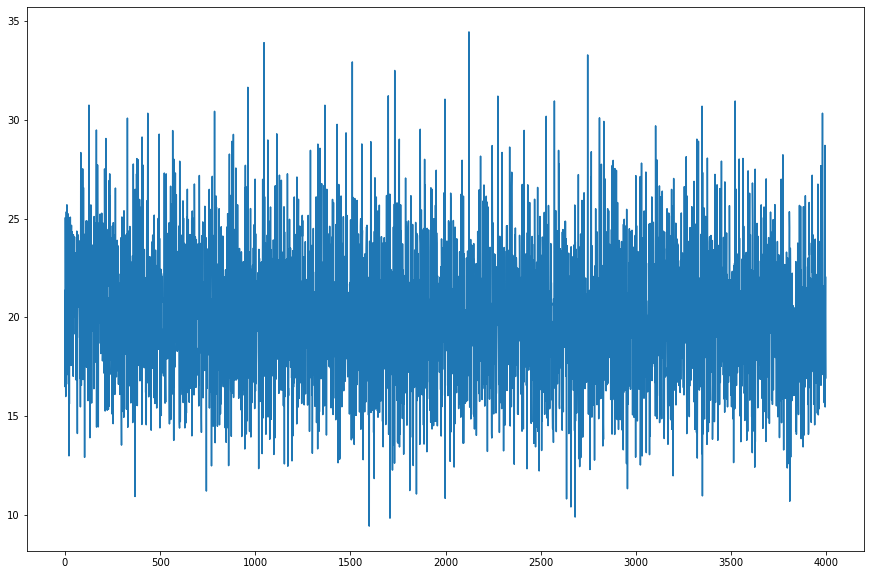

In [100]:
plt.plot(error_list)

In [101]:
# ค่า Weight ที่ได้จาก NN 
#W

In [102]:
# ค่า Bias ที่ได้จาก NN
#B

# Make Prediction on Train Data

In [103]:
Z_Train, A_Train = NN_forward(A0_Train, W, B, AF)

In [104]:
N_Train = T_Train.shape[0]
N_Train

2500

In [105]:
error_Train = find_error(T_Train, A_Train[-1], 'Binary')
error_Train

34.48

In [106]:
AccTrain = 100*(np.round(T_Train,0) == np.round(A_Train[-1])).sum()/N_Train
AccTrain

65.52

# Make Prediction on Test Data

In [107]:
Z_Test, A_Test = NN_forward(A0_Test, W, B, AF)

In [108]:
N_Test = T_Test.shape[0]
N_Test

326

In [109]:
error_Test = find_error(T_Test, A_Test[-1], 'Binary')
error_Test

36.809815950920246

In [110]:
AccTest = 100*(np.round(T_Test,0) == np.round(A_Test[-1])).sum()/N_Test
AccTest

63.190184049079754

In [111]:
Value = A_Test[-1]
Real = np.round(T_Test,0)
Predict = np.round(A_Test[-1])
Results = np.hstack((Real,Value,Predict))
Compare = pd.DataFrame(Results,columns = ['Real Trend', 'Value Sigmoid','Predict Trend'])
Compare.tail(20)

,Real Trend,Value Sigmoid,Predict Trend
306,0.0,0.294479,0.0
307,0.0,0.431621,0.0
308,1.0,0.795907,1.0
309,0.0,0.108490,0.0
310,1.0,0.717103,1.0
311,1.0,0.680816,1.0
312,1.0,0.680816,1.0
313,1.0,0.589567,1.0
314,0.0,0.456280,0.0
315,0.0,0.346188,0.0


# Future Prediction

In [112]:
DataPredict = df.copy()
DataPredict

,BBands,Mom,RSI,ADX,MACD,EMA,CCI,ROC,WILLR,SAR,Target
Date,,,,,,,,,,,
2011-01-03,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2011-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
2021-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [113]:
DataMatrix = DataPredict.values

In [114]:
A1      = DataMatrix[:, :10]
A1_Test = A1[-1: , :]

In [115]:
A1

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan,  1.],
       [nan, nan, nan, ..., nan, nan,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  0.]])

In [116]:
A1_Test

array([[1., 1., 1., 0., 0., 1., 1., 1., 1., 0.]])

In [117]:
Z_Test, A1_Test = NN_forward(A1_Test, W, B, AF)

In [118]:
Value = A1_Test[-1]
Predict = np.round(A1_Test[-1])
Results = np.hstack((Value,Predict))
Compare = pd.DataFrame(Results,columns = ['Sigmoid','Trend'])
Compare

,Sigmoid,Trend
0,0.385727,0.0


In [119]:
print('Predict Tomorrow Trend is ', Predict )

Predict Tomorrow Trend is  [[0.]]


 1 is Uptrend, 0 is Downtrend